In [41]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data/spectra_microalgae.txt", sep="\t")
df

,300,300.5,301,301.5,302,302.5,303,303.5,304,304.5,...,796,796.5,797,797.5,798,798.5,799,799.5,800,Species
0,0.425824,0.440542,0.459128,0.479346,0.489588,0.495581,0.501271,0.504685,0.506885,0.512157,...,-0.000114,0.000228,0.000076,-0.000303,0.000228,-0.000038,-0.000607,-0.000341,0.000000,Chlo
1,0.626594,0.633921,0.640381,0.648773,0.654734,0.660462,0.665790,0.672217,0.676180,0.680742,...,-0.000100,-0.000733,-0.000799,-0.000033,-0.000133,0.000033,0.000400,-0.000333,0.000000,Chlo
2,0.640927,0.646844,0.656517,0.667586,0.674501,0.680384,0.687365,0.691454,0.693681,0.701426,...,0.000166,0.000665,0.001163,0.002127,0.001695,0.001729,0.001429,0.000332,0.000000,Chlo
3,0.694577,0.700013,0.706611,0.714271,0.720920,0.722235,0.725496,0.726710,0.729364,0.734066,...,0.000935,0.000657,0.000329,0.000000,-0.000126,-0.000480,-0.000253,-0.000101,0.000000,Chlo
4,0.706483,0.709274,0.713681,0.718038,0.722715,0.728664,0.731112,0.733878,0.736425,0.738750,...,0.000588,0.000514,0.000783,0.000490,0.000343,0.000098,-0.000122,0.000024,0.000000,Chlo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2.030725,2.093962,2.150768,2.219721,2.309039,2.369418,2.415506,2.500179,2.559486,2.613433,...,-0.025009,-0.020364,-0.001429,-0.005716,-0.000715,0.001429,0.002858,-0.006074,0.000000,Pav
97,0.523065,0.694292,0.931196,1.175919,1.410477,1.512119,1.686474,1.810790,1.992963,2.142299,...,0.240031,0.235340,0.254887,0.246286,0.249414,0.243941,0.244722,0.238468,0.240031,Pav
98,2.597315,2.705488,2.816028,2.915515,3.014607,3.087643,3.107777,3.165811,3.247138,3.294907,...,-0.003553,-0.012633,0.006711,-0.003948,-0.000395,-0.012238,-0.003948,-0.014212,0.000000,Pav
99,1.650368,1.687653,1.751284,1.816700,1.853092,1.874302,1.911364,1.919178,1.933914,1.965171,...,-0.004242,-0.008707,-0.009600,-0.000670,-0.004242,-0.000447,0.002233,0.007368,0.000000,Pav


In [22]:
n_features = len(df.columns) - 1

In [16]:
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

In [27]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
import numpy as np

In [25]:
def exponential_dilation(r): return lambda x: (1 - np.exp(-r*x))

In [38]:
def objective(trial):
    X_dilated = exponential_dilation(trial.suggest_float("dilation_coefficient",0,1))(X)
    kf = KFold(n_splits = 10, shuffle = True)
    n_pca_components = trial.suggest_int("pca_components", 3, 90)
    pca = PCA(n_components=n_pca_components)
    corr = []
    for ix_train, ix_test in kf.split(X_dilated):
        model = KNeighborsClassifier(n_neighbors=trial.suggest_int("n_neighbors",3,10), metric=trial.suggest_categorical("knn_metric",['minkowski', 'euclidean', 'cosine']))
        X_train, y_train = X[ix_train], y[ix_train]
        X_test, y_test = X[ix_test], y[ix_test]
        U_train = pca.fit_transform(X_train)
        U_test = pca.transform(X_test)
        model.fit(U_train, y_train)
        y_pred = model.predict(U_test)
        corr.append(matthews_corrcoef(y_test, y_pred))
    return np.mean(corr) - 0.01*n_pca_components

In [39]:
study = optuna.create_study(storage="sqlite:///data/optuna.sqlite", direction='maximize', study_name='KNN with PCA', load_if_exists=True)
study.optimize(objective, n_trials = 100)

[I 2024-10-28 06:02:18,024] A new study created in RDB with name: KNN with PCA
[I 2024-10-28 06:02:21,039] Trial 0 finished with value: 0.5510429436791875 and parameters: {'dilation_coefficient': 0.09402625806109721, 'pca_components': 26, 'n_neighbors': 6, 'knn_metric': 'euclidean'}. Best is trial 0 with value: 0.5510429436791875.
[I 2024-10-28 06:02:24,062] Trial 1 finished with value: -0.0043819879439535026 and parameters: {'dilation_coefficient': 0.6282126151848858, 'pca_components': 81, 'n_neighbors': 6, 'knn_metric': 'euclidean'}. Best is trial 0 with value: 0.5510429436791875.
[I 2024-10-28 06:02:26,080] Trial 2 finished with value: 0.7226404170343893 and parameters: {'dilation_coefficient': 0.650094803675594, 'pca_components': 17, 'n_neighbors': 5, 'knn_metric': 'cosine'}. Best is trial 2 with value: 0.7226404170343893.
[I 2024-10-28 06:02:30,193] Trial 3 finished with value: 0.4338201500047974 and parameters: {'dilation_coefficient': 0.42868737349594466, 'pca_components': 35, '

In [40]:
study.best_params

{'dilation_coefficient': 0.05084146355224646,
 'pca_components': 5,
 'n_neighbors': 5,
 'knn_metric': 'cosine'}

In [44]:
pca = PCA(n_components=study.best_params['pca_components'])
X_transformed = exponential_dilation(study.best_params['dilation_coefficient'])(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, stratify=y)
U_train = pca.fit_transform(X_train)
U_test = pca.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=study.best_params['n_neighbors'], metric=study.best_params['knn_metric'])
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
matthews_corrcoef(y_true=y_test,y_pred=y_pred)

np.float64(0.9498776699868771)

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
udf_train = pd.DataFrame(U_train)
udf_train['labels'] = y_train

<Figure size 640x480 with 0 Axes>

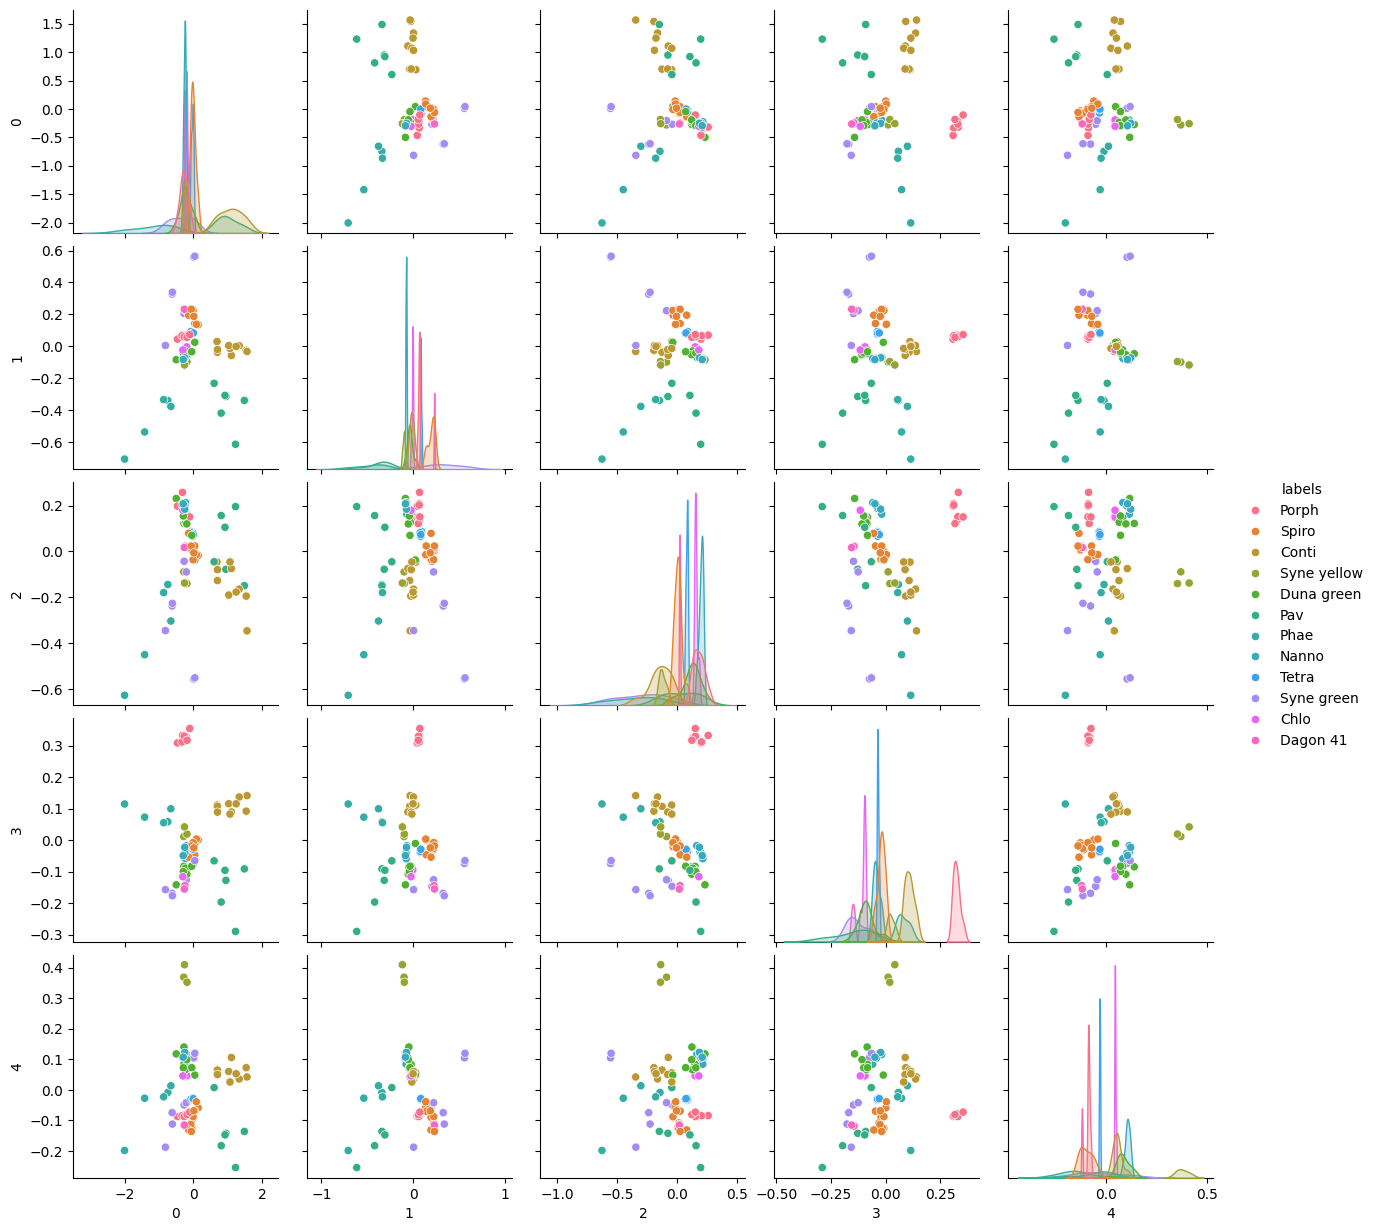

In [54]:
plt.figure()
sns.pairplot(udf_train, hue='labels')
plt.show()